# ADAlyzers final project.


### Structure of the notebook.


1. Introduction.
    - What is the project about
        - Questions, etc.
    - How will we solve the problem?
2. Data description + processing.
    - General overview
        - Size of data
        - Types of data
    - Data cleaning
        - Decisions: Explain everything leading to final dataframe.
3. Featurizing. For each item: Intro + data analysis + methods.
    - Semantic similarity
    - Positional encoding
        - Images
        - Relative to paragraph
    - Curvature
4. Statistical analysis.
    - Matching
    - Tests
    - Conclusions.

---

# 1. Introduction.

Players follow different strategies.

Is the implementation of some strategy in particular correlated to success in this game? Or better, can we recommend a particular strategy to play wikispeedia?

Here, we will answer these questions by exploring a database of over 100k recorded games from real users, by using tools from natural language processing, web scrapping and network analysis, among others.

---

# 2. Data description + processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse
import seaborn as sns
import os, sys

In [2]:
data_path = "data/"
parent_folder_path = data_path + 'wikispeedia_paths-and-graph/'

paths_finished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                               sep='\t', skiprows=15, header=None)
                   .rename(columns={0:"ip",
                                    1:"timestamp",
                                    2:"duration",
                                    3:"path",
                                    4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))
articles_df=pd.read_csv(os.path.join(parent_folder_path, 'articles.tsv'), 
                        sep='\t', skiprows=12, header=None, names=['article'])

### Hyperlinks clickability: positioning throughout the text 

To get the distribution of players' clickability preference with regard to the positioning of the hyperlinks throughout the article text, the following protocol is implemented:
1. parse Wikispeedia articles html files in order to get the **most frequent positioning*** per each hyperlink;
2. parse the **human paths** (i.e. sequence of clicked articles) and attribute to each link its most frequent positioning (on the basis of the categorization above);
3. group by **positioning**** and count the **number of occurences*****;
4. normalize;
5. plot the distributions of successful and unsuccessful players. 

\*each article is divided into paragraphs: on the basis of the relative (to the article length) paragraph the hyperlink shows up, it is assigned a categorical label, which indicates its positioning; then, to each hyperlink name, its most frequent label, throughout the Wikispeedia library, it is assigned. <br>
\*\*`positioning` is a categorical variable with possible labels `top`, `top-center`, `center`, `center-bottom`, `bottom`. <br>
\*\*\* do this separately for successful and unsuccessful players.

`most_freq_positioning_df` stores the most frequent positionings for each hyperlink:

In [3]:
most_freq_positioning_df=pd.read_csv('processed/most_freq_positioning_df.csv', index_col=0)
most_freq_positioning_df.tail()

,link,most_freq_positioning
10528,‘6 villages for 2006’,center-bottom
10529,“6 villages for 2006”,center
10530,€,center-bottom
10531,€25 million,top
10532,↑,center


In [4]:
folder_plots='./P2_plots_dfs/'

In [5]:
links_freq_pos_f=pd.read_csv(folder_plots+'links_freq_pos_f.csv', index_col=0)
links_freq_pos_f

,link,#_clicks,most_freq_positioning
0,áedán mac gabráin,0.0,center-bottom
1,åland,1.0,bottom
2,édouard manet,1.0,center-bottom
3,éire,1.0,top
4,óengus i of the picts,0.0,NaN
...,...,...,...
11515,‘6 villages for 2006’,NaN,center-top
11516,“6 villages for 2006”,NaN,center
11517,€,NaN,center-bottom
11518,€25 million,NaN,top


In [6]:
from PIL import Image
with Image.open(folder_plots+"Distribution_clickability_preference_pos.png") as im:
    im.show()
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


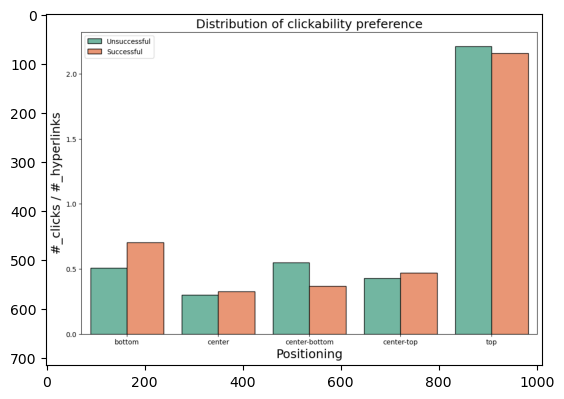

In [7]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("./P2_plots_dfs/Distribution_clickability_preference_pos.png")
imgplot = plt.imshow(img)
plt.show()

### Hyperlinks clickability: image captions

To get the distribution of players' clickability preference with regard to the positioning of the hyperlinks throughout the article text, the following protocol is implemented:
1. parse Wikispeedia articles html files in order to get the **list of hyperlinks** that show up **in image captions**;
2. parse the **human paths** (i.e. sequence of clicked articles) and count the clicked hyperlinks that show up in image captions (on the basis of the categorization above);
3. group by a hyperlink being in an **image captions*** or not and count the **number of occurences**;
4. normalize;
5. plot the distributions. 

\*`in_image` is a binary variable indicating whether the hyperlink shows up in image captions or not. 

`links_in_images_list` stores the list of links present in image captions:

In [8]:
link_in_img_list=pd.read_csv('processed/links_in_images_unique.csv', index_col=0).values[:,0].tolist()
link_in_img_list[:5]

['bangladesh', 'portsmouth', 'england', 'india', 'pompeii']

In [9]:
with Image.open("./P2_plots_dfs/Distribution_clickability_preference_img.png") as im:
    im.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


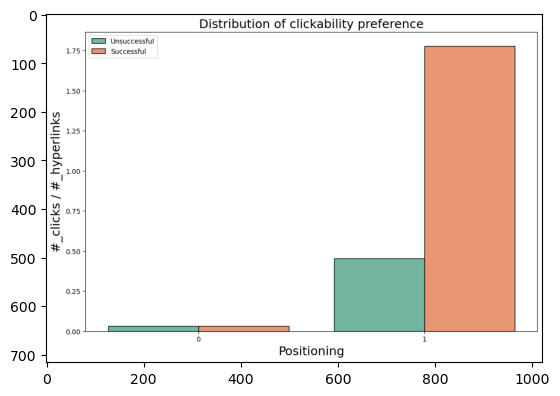

In [10]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("./P2_plots_dfs/Distribution_clickability_preference_img.png")
imgplot = plt.imshow(img)
plt.show()

# Dataset Processing

The methodology chosen for the data processing step is to perform a **matched analysis** with the final objective to test if specific players' game strategies lead to success in the Wikispeedia game. 
A logistic regression is conducted with the goal to estimate the parameters of the logistic model with the dependent binary variable being the success (or NOT success) and the independent variables being sequentially extracted the following set of features (different players' choices when playing the Wikispeedia game):
1. **Positioning** of the clicked hyperlinks;
2. Clicking hyperlinks in **image captions**;
3. Clicking articles with the following **semantic similarity patterns**:
   -  increasing semantic similarity along the path between articles and the target article;
   -  increasing semantic similarity along the path between two sequentially clicked articles.
   
Several **confounders** may affect the outcome of the regression analysis i.e. of the potentially found correlation between the aforementioned features and success. <br>
To mention a few, the **“difficulty”** of the randomly assigned task (source and target articles), affects the players' successfulness together with the strategy adopted to address it. This “difficulty” could be naively measured by **shortest path distance** between the source and target article in the Wikispeedia hyperlinks graph (calculated with the Floyd-Warshall algorithm). <br>
Additionally, the **characteristics** (e.g. **nodes in- and out-degree**, **path legth**) of the "human path" (i.e. the actual sequence of clicked hyperlinks by the player), again reasonably affects players successfulness and their choice for a strategy.  
### Andres comment curvature features


In order to remove the aforementioned confounders, the dataset is filtered and the matching is performed accordingly with the assumptions made. 
Players are matched on same **shortest path distance** of the assigned task, and maximum **propensity score** (see __Statistical analysis__), with the **treated subject** being the user performing a specific strategy (e.g. clicking more frequently than the average on hyperlinks showing up in images’ captions) and the **controlled subject** being the user NOT performing the strategy. 

The analysis challenge can be reformulated as follows: **“being assigned an equally difficult task and being equally free to perform a specific strategy, are players more successful if they adopt that specific strategy?”**

`shortest_path_matrix` stores the shortest path distances from all source articles to all target articles. 

In [11]:
# first read the shortest path matrix
shortest_path_matrix = []

with open(data_path + 'wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)

In [12]:
# next, we need a list of all the article names. The order of the articles 
# is the same as the shortest_path_matrix as per the file descriptions

import urllib.parse
def str_url_format(word):
    """
    Article name preprocessing.
    
    Apply this function any time a new dataframe is loaded.
    """
    return (urllib.parse.unquote(word)
            .replace("_", " ")
            .strip()
            .lower())

article_names_cleaned = (pd.read_csv(data_path + 'wikispeedia_paths-and-graph/articles.tsv', 
                                     sep='\t', 
                                     skiprows=11,
                                     header=None)[0]
                         .apply(str_url_format)
                         .values
                         .tolist()
                        )

article_names_cleaned[:3]

['áedán mac gabráin', 'åland', 'édouard manet']

`successful_df` and `unsuccessful_df` dataframes store all players attempts to the Wikispeedia game. Each row contains:
- `path`, sequence of clicked articles;
- `source_article`, `target_article`, source and target articles of the assigned task;
- `shortest_path_length`, shortest path distance between source and target article;
- `human_path_length`, length of `path`. <br>

The two dataframes are then filtered for `human_path_length` greater than 3 as a human path length equal to 1 would mean the player did not perform any choice and with a human path length equal to 2, no sequential behavior could be measured by us, data analysts.  

In [13]:
# for each human path, perform the following steps:
#      1. extract the source and target article
#      2. find the *index* in the article names list that corresponds to the source and target article
#      3. the corresponding *index* row in the shortest path matrix corresponds to the source article. 
#         from this list of numbers, use the target article *index* to find the *shortest path length*

def augment_with_shortest_path(df: pd.DataFrame, successful: bool) -> pd.DataFrame:
    """
    this function takes a Series and returns a DataFrame with the following columns:
       1. path
       2. source article
       3. target article
       4. shortest path length
       
    input:
       df: the Pandas DataFrame containing all the human navigation paths
       successful: a boolean indicating whether the paths were successful or not
    """
    # remove all paths with back-tracks
    df = df[~df['path'].str.contains('<')]        
    paths, human_path_lengths, source_articles, target_articles, shortest_paths = [], [], [], [], []
    
    # all information required for successful paths is in the path itself
    if successful:
        for human_path in df['path']:

            split_path = str_url_format(human_path).split(";")
            
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            target = split_path[-1]
            source_articles.append(source)
            target_articles.append(target)
    
    # unsuccessful paths require extraction of the target article from a separate column
    else:
        for human_path, target in zip(df['path'], df['target']):
            
            split_path = str_url_format(human_path).split(";")
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            target = str_url_format(target)
            source_articles.append(source)
            target_articles.append(target)
        
    for source, target in zip(source_articles, target_articles):
        source_index = article_names_cleaned.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = article_names_cleaned.index(target)
        except Exception:
            shortest_paths.append("N/A")
            continue
            
        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("Impossible")
        else:
            shortest_paths.append(int(shortest))
        
        
    # create the augmented DataFrame
    out = pd.DataFrame({
                      'path': paths,
                      'source_article': source_articles,
                      'target_article': target_articles,
                      'human_path_length': human_path_lengths,
                      'shortest_path_length': shortest_paths
                      })
    
    return out

In [14]:
successful_df = augment_with_shortest_path(df=paths_finished_df, successful=True)
# to investigate human behaviour, we remove all "Impossible paths" and also shortest_path_length = 0
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x != 'Impossible' and x != 0))]

successful_df = successful_df[(successful_df['human_path_length'].apply(lambda x: x >= 3))]

successful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3


In [15]:
unsuccessful_df = augment_with_shortest_path(df=paths_unfinished_df, successful=False)

# some target articles for unsuccessful paths were not provided in the plain_text folder, denoted in
# the DataFrame as "N/A". Remove these
unsuccessful_df = (unsuccessful_df[(unsuccessful_df['shortest_path_length']
                                    .apply(lambda x: x != 'N/A' and x != 'Impossible'))])

unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: x >= 3))]

unsuccessful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
5,agriculture;history of the world;china;yangtze...,agriculture,grand canal of china,3,3
6,mind;christianity;europe;renaissance;ancient g...,mind,scouting,6,4
7,4-2-0;united states;agriculture;sugar;australia,4-2-0,cane toad,4,5


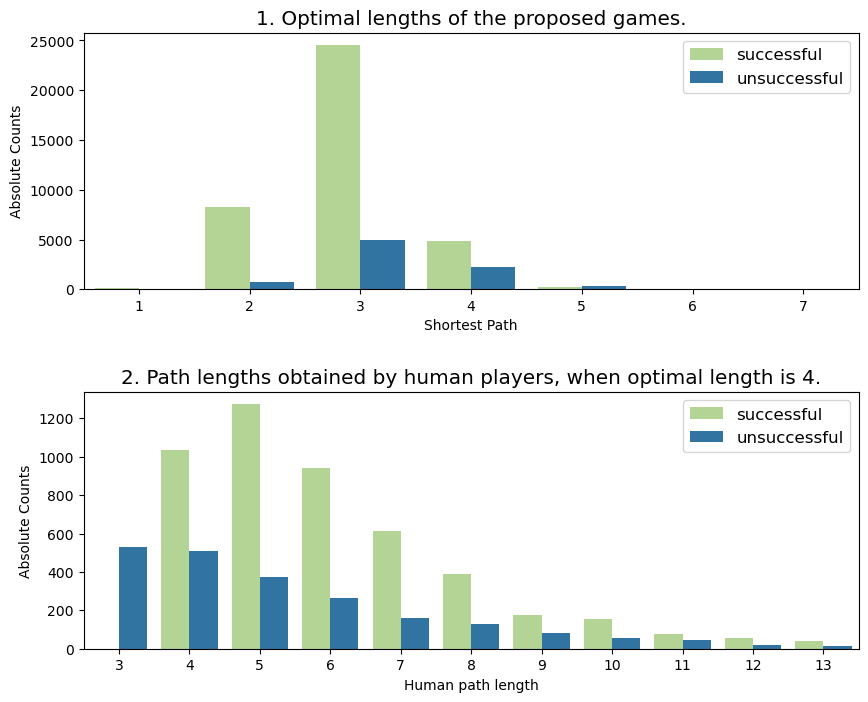

In [16]:
# This replaces the old plots. more concise xx


# take a look at the shortest_path distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2,1, 
                       figsize=(10,8), 
                       gridspec_kw={"hspace":0.4})
plt.rcParams["font.size"] = 12


successful_counts = (successful_df['shortest_path_length']
                     .value_counts()
                     .reset_index())
successful_counts["success"] = "successful"

unsuccessful_counts = (unsuccessful_df['shortest_path_length']
                       .value_counts()
                       .reset_index())
unsuccessful_counts["success"] = "unsuccessful"

all_counts = pd.concat([successful_counts, 
                        unsuccessful_counts], 
                       axis=0)

sns.barplot(data=all_counts, 
            x="index", 
            y="shortest_path_length", 
            hue="success",
            ax=ax[0], 
            palette=["#b2df8a", "#1f78b4"])

ax[0].set_ylabel('Absolute Counts'); 
ax[0].set_xlabel('Shortest Path');
ax[0].set_title("1. Optimal lengths of the proposed games.")
#Count of human paths, stratified by shortest possible path")

ax[0].legend(loc=1)
ax[0].set_ylabel('Absolute Counts') 
ax[0].set_xlabel('Shortest Path')



# Next plot: frequency by human length
n = 4
successful_human_path_lengths_n = (successful_df
                                   [successful_df['shortest_path_length'] == n]
                                   ['human_path_length']
                                   .value_counts()
                                   .reset_index())

successful_human_path_lengths_n["success"] = "successful"

unsuccessful_human_path_lengths_n = (unsuccessful_df
                                     [unsuccessful_df['shortest_path_length'] == n]
                                     ['human_path_length']
                                     .value_counts()
                                     .reset_index())

unsuccessful_human_path_lengths_n["success"] = "unsuccessful"

all_path_ln = pd.concat([successful_human_path_lengths_n,
                         unsuccessful_human_path_lengths_n])

sns.barplot(data=all_path_ln, 
            x="index", 
            y="human_path_length", 
            hue="success", 
            ax=ax[1],
            palette=["#b2df8a", "#1f78b4"])

ax[1].set_xlim(-0.5,10.5)

ax[1].set_ylabel('Absolute Counts')
ax[1].set_xlabel('Human path length')
ax[1].set_title(f"2. Path lengths obtained by human players, when optimal length is {n}.")
# Count of human path lengths, with shortest possible path = n");

ax[1].legend(loc=1);

The majority of tasks have shortest path length equal to 3, among both successful and unsuccessful players. For this shortest pasth distance, the distribution of successful vs unsuccessful players is strongly unbalanced; for shortest path distance equal to 4, instead, the gap is roughly 7 times smaller, i.e. the distributions are more balanced. In the former scenario, the value of shortest path distance of the task (a naive measure of "difficulty") may be the underlying motivation of the uneven distribution. However it is of more interest for the purpose of our analysis to deepen the inquiry on the **more balanced dataset**, as we still have **large amount of data** to test.

The dataframes are therefore filtered for `shortest_path_distance`==4. 

The binary variable `is_successful` accounting for players' success in the game is added to the dataframes, before concatting them into the `final_df` dataframe, ready for **Featurization** and **Statistical analysis** steps. 

In [17]:
successful_df['is_successful'] = 1
unsuccessful_df['is_successful'] = 0

# merge the successful and unsuccessful DataFrames
final_df = pd.concat([successful_df, unsuccessful_df])
final_df.reset_index(drop=True, inplace=True)

final_df.head(3)

# save the DataFrame
final_df.to_csv('processed/final_df.csv', index=False)

# next, we will calculate "treatments" involving semantic distance metrics for the DataFrame

---

# 3. Featurization

### Human paths characteristics: length, curvature

The features holding the information on **human paths characteristics** are extrapolated as follows:

In [18]:
# Load graph 

df_links = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/links.tsv", 
                        skiprows=12, 
                        sep="\t", 
                        header=None)
            .applymap(str_url_format)
            .rename(columns={0:"src",
                             1:"tgt"})
           )

def split_decode_path(path):
    return list(map(
        str_url_format, 
        path.split(";")
    ))

df_paths_success = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/paths_finished.tsv", 
                          skiprows=15, 
                          sep="\t", 
                          header=None)
                    .rename(columns={0:"ip",
                                     1:"timestamp",
                                     2:"duration",
                                     3:"path",
                                     4:"rating"})
         )
# Create a "target" col
df_paths_success["target"] = (df_paths_success["path"]
                              .apply(lambda x: (str_url_format(x)
                                                .split(";")[-1])))
df_paths_success["type"] = "win"


df_paths_fail = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/paths_unfinished.tsv", 
                             skiprows=16, 
                             sep="\t", 
                             header=None)
                 .rename(columns={0:"ip",
                                  1:"timestamp",
                                  2:"duration",
                                  3:"path",
                                  4:"target",
                                  5:"type"})
             )

# Join dfs to get a full df with all paths
df_paths = pd.concat([df_paths_success,
                      df_paths_fail])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(str_url_format)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
21356,0c4d5d1d140bfbb1,1377726452,1813,Brain;Emotion,NaN,telephone,timeout,"[brain, emotion]",brain
10275,6bdb582d02e0adbf,1344723829,1883,Brain;Computer_science;Programming_language;<;...,NaN,telephone,timeout,"[brain, computer science, programming language...",brain
10009,216903184a5219ef,1344190208,135,Continent;Asia;Deluge_%28mythology%29;Tsunami,NaN,gorilla,restart,"[continent, asia, deluge (mythology), tsunami]",continent
2962,1bc1fe9b0cce91df,1304230408,1816,Silent_film;20th_century,NaN,avocado,timeout,"[silent film, 20th century]",silent film
23210,3a58922b0835e182,1384016498,146,Archaeopteryx;London;Mass_media;Newspaper;Adve...,NaN,photography,restart,"[archaeopteryx, london, mass media, newspaper,...",archaeopteryx


In [19]:
# Merge all dfs that count node properties:
# in-degree, out-degree, use as start, use as target

freq_out = df_links['src'].value_counts()
freq_in = df_links['tgt'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='outer')
               .fillna(0)
               .rename(columns={"src":"out",
                                "tgt":"in"}))

degree_freq.head()

from itertools import chain
degree_connect = (
    degree_freq
    .merge(
        # Count how many times an article was used as target
        df_paths["target"].value_counts(),
        left_index=True,
        right_index=True,
        how="outer"
    )
    .merge(
        # Count how many times an article was used as starting point
        df_paths["start"].value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
    .merge(
        # Count how many times an article was clicked
        pd.Series(
            list(chain(
                *df_paths["pathl"].values
            )), 
            name="clicks"
        )
        .value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
)

degree_connect

,in,out,target,start,clicks
1 ceres,12.0,32.0,11.0,7.0,137.0
10th century,65.0,26.0,7.0,13.0,150.0
11th century,57.0,48.0,13.0,17.0,141.0
12th century,85.0,45.0,10.0,25.0,169.0
13th century,84.0,34.0,34.0,13.0,175.0
...,...,...,...,...,...
åland,0.0,19.0,NaN,NaN,4.0
édouard manet,0.0,20.0,NaN,NaN,7.0
éire,0.0,8.0,NaN,NaN,13.0
óengus i of the picts,0.0,10.0,NaN,NaN,NaN


In [20]:
# Let's calculate curvature for each edge in the graph

# get in-degree(`in`) and out-degree(`out`)
curv_edge = (
    df_links
    .merge(
        (degree_connect[["in"]]
         .rename(columns={"in":"in-degree(src)"})),
        left_on="tgt", 
        right_index=True,
        how="outer")
    .merge(
        (degree_connect[["out"]]
         .rename(columns={"out":"out-degree(tgt)"})),
        left_on="src", 
        right_index=True,
        how="outer")
)

# Calculate curvature
curv_edge["curvature"] = 2 - curv_edge["in-degree(src)"] - curv_edge["out-degree(tgt)"]

curv_edge.sample(5)

,src,tgt,in-degree(src),out-degree(tgt),curvature
13027.0,basset hound,rabbit,22.0,9.0,-29.0
9209.0,armenia,moldova,47.0,186.0,-231.0
105852.0,telephone exchange,telecommunication,18.0,3.0,-19.0
51387.0,history of the internet,tim berners-lee,8.0,30.0,-36.0
67665.0,lutetium,color,157.0,27.0,-182.0


In [21]:
# ADD features to final df

# First get, for every path, a sequence of nodes.

# TODO: Think abt what to do with paths containing `<`

# For convenience, let's drop paths contatining '<' for now
df_paths_clean = (final_df[final_df["path"]
                           .apply(lambda x: '<' not in x)])
df_paths_clean["pathl"] = df_paths_clean.path.str.split(";")

def list_nodes(pathl):
    return [
        [pathl[i],pathl[i+1]]
        for i in range(len(pathl)-1)
    ]
    
# Array to index edge -> curvature 
indx_curva = (curv_edge
              .set_index(["src", "tgt"])
              .loc[:,"curvature"])
def path_curvature(row):
    try:
        return (indx_curva
                .loc[row["edgel"]]
                .values)
    except:
        return []

df_paths_clean["edgel"] = df_paths_clean["pathl"].apply(list_nodes)
df_paths_clean["path_curv"] = df_paths_clean.apply(path_curvature, axis=1)

df_paths_clean.head()

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,pathl,edgel,path_curv
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,"[14th century, 15th century, 16th century, pac...","[[14th century, 15th century], [15th century, ...","[-129.0, -180.0, -274.0, -335.0, -130.0, -488...."
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,"[14th century, europe, africa, atlantic slave ...","[[14th century, europe], [europe, africa], [af...","[-962.0, -634.0, -225.0, -63.0]"
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,"[14th century, niger, nigeria, british empire,...","[[14th century, niger], [niger, nigeria], [nig...","[-94.0, -148.0, -207.0, -245.0, -577.0, -225.0..."
3,14th century;renaissance;ancient greece;greece,14th century,greece,3,2,1,"[14th century, renaissance, ancient greece, gr...","[[14th century, renaissance], [renaissance, an...","[-151.0, -224.0, -309.0]"
4,14th century;italy;roman catholic church;hiv;r...,14th century,john f. kennedy,6,3,1,"[14th century, italy, roman catholic church, h...","[[14th century, italy], [italy, roman catholic...","[-579.0, -331.0, -101.0, -83.0, -250.0, -115.0]"


In [ ]:
import numpy as np


final_df_curv = df_paths_clean.drop(columns=["pathl", "edgel"])

def curv_features(path_curv):
    """
    Calculate curvature features of a path.
    
    With the curvature of the edges in the path, calc a fixed length vector that (approx) describes it.
    """
    path_curv = pd.Series(path_curv, dtype=np.float64)
    p_curv_diff = np.diff(path_curv)
    
    descr = path_curv.describe()
    descr2 = pd.Series(p_curv_diff).describe()
    
    return pd.concat([descr, descr2]).reset_index(drop=True)


curv_feats = final_df_curv["path_curv"].apply(curv_features)

final_df_curv = pd.concat([final_df_curv
                           .drop(columns="path_curv"),
                           curv_feats],
                          axis=1)

final_df_curv = final_df_curv.rename(columns={i:f"curv_feats_{i}" for i in range(16)})

final_df_curv.to_csv("processed/final_df_curv_feats.csv", index=False)
final_df_curv.head(3)

### Hyperlinks' positioning

The features holding the information on **hyperlinks' positioning clickability** are extrapolated as follows:
1. to each hyperlink clicked in the human path it is assigned its most frequent positioning*;
2. for each path the distribution of the 5 categorical positioning (top, center-top, center, center-bottom,bottom) of hyperlinks is calculated (their relative frequency: numerical predictor).
3. the values of the features are standardized**.

*its most frequent positioning is determined on the basis of its occurencies in the set of articles making up the Wikispeedia html files database.

In [ ]:
most_freq_positioning_df=pd.read_csv('processed/most_freq_positioning_df.csv', index_col=0)
most_freq_positioning_df.head()

In [ ]:
def find_features(human_path):
    '''this function determines the categorical positioning feature of each hyperlink in the human path'''
    return [most_freq_positioning_df.loc[link].values.item() 
                         if link in most_freq_positioning_df.index \
                         else np.random.choice(['top', 'center-top','center','center-bottom', 'bottom'])
                         for link in human_path] #certain hyperlinks were not classified 

final_df_postioning = final_df_curv['path'].apply(lambda x: x.split(";")).apply(lambda x: find_features(x))

def find_features_frequency(features):
    '''this function counts the frequency of the categorical positioning features of the hyperlinks in each human path'''
    t, ct, c, cb, b=[], [], [], [], []

    for path in features:
        t.append(path.count('top'))
        ct.append(path.count('center-top'))
        c.append(path.count('center'))
        cb.append(path.count('center-bottom'))
        b.append(path.count('bottom'))
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

successful_features_freq = find_features_frequency(final_df_postioning)

final_df_feats = (pd.concat([final_df_curv, successful_features_freq], 
                            axis=1)
                  .dropna())
final_df_feats.head(3)

### Hyperlinks in image captions

The feature holding the information on **hyperlinks in image captions clickability** is extrapolated as follows:
- for each human path the numerosity of hyperlinks showing up in images captions is counted (numerical predictor);
- the value is standardized.

In [ ]:
link_in_img_list=pd.read_csv('processed/links_in_images_unique.csv', index_col=0).values[:,0].tolist()
link_in_img_list

#list of unique hyperlinks showing up in images'captions

#count number of hyperlinks in images' captions in each path

final_df_feats['count_images'] = (final_df['path']
                                 .apply(lambda x: x.split(";"))
                                 .apply(lambda x: np.isin(x, link_in_img_list).sum()
                                        if np.isin(x, link_in_img_list).sum() else 0)
                                )

### Semantic similarity 

---

# 4. Statistical analysis

### Calculation of propensity score 

The purpose motivating the matched analysis is to obtain a "balanced" testing dataset, with subjects actually comparable. In fact, we want to test potential correlation (causation ?) between specific strategies performed and players' success. The players tested should then be at the same starting point when choosing what strategy to adopt, i.e. have same probability to get the treatment (a.k.a. propensity score).   
The **propensity scores** are obtained by calculating the **predicted outcomes of a logistic regression** with the dependent variable being the boolean treatment variable `treat` and the independent variables being selected features, namely:
- human path length `human_path_length`;
- curvature;
- 
- 
- <br>

The **treated subject** is the user performing the specific strategy, the **controlled subjct** is the user NOT performing the specific startegy. The following tretments will be tested:
1. Players clicking in hyperlinks showing up at the top of articles;
2. Players clicking in hyperlinks showing up at the top-center of articles;
3. Players clicking on hyperlinks showing up in image captions;
4. Players clicking articles with sequentially increasing similarity between the two;
5. Players clicking articles with increasing similarity with the target article;

The **label** is players' success `is_successful`.

In [ ]:
# Let's center our attention on paths with optimum length == 4
# Here tasks are harder, and so classes (succcess/unsuccess) are more balanced.
# Also less data -> matching is faster

final_df_filt = final_df_feats.query("shortest_path_length == 4")
final_df_filt.is_successful.value_counts()

In [ ]:
import networkx as nx
from tqdm.notebook import tqdm

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [ ]:
import statsmodels.api
import statsmodels.formula.api as smf
from itertools import chain 

# Generate the features + standardize
y_treatment = ((final_df_filt.top/final_df_filt.human_path_length) > 0.5)*1
X_feats = (final_df_filt
           .loc[:,final_df_filt
                .columns
                .str
                .startswith("curv_feats")])

X_feats = (X_feats - X_feats.mean(axis=0))/X_feats.std(axis=0)

# Calc prop score (w logistic regr)
df_regr = pd.concat([X_feats, y_treatment.rename("treat")], axis=1)

model = smf.logit(formula='treat ~ '+ '+'.join(X_feats.columns), data=df_regr)
res = model.fit()

# Add treatment flag to df
final_df_filt["treatment_top"] = y_treatment

# Add prop score to df
final_df_filt["prop_scores_top"] = res.predict()

# Separate the treatment and control groups
treatment_df = final_df_filt[final_df_filt['treatment_top'] == 1]
control_df = final_df_filt[ final_df_filt['treatment_top'] == 0]

### Matching 

In [ ]:
## Separate the treatment and control groups
#treatment_df = final_df_filt[final_df_filt['treatment_top'] == 1]
#control_df = final_df_filt[ final_df_filt['treatment_top'] == 0]
#
## Create an empty undirected graph
#G = nx.Graph()
#
## Loop through all the pairs of instances
#for control_id, control_row in tqdm(control_df.iterrows(), total=control_df.shape[0]):
#    for treatment_id, treatment_row in treatment_df.iterrows():
#
#        # We control for task difficulty (more general in case we don't pre-filter)
#        if control_row["shortest_path_length"] == treatment_row["shortest_path_length"]:
#
#            # Calculate the similarity 
#            similarity = get_similarity(control_row['prop_scores_top'],
#                                        treatment_row['prop_scores_top'])
#
#            # Add an edge between the two instances weighted by the similarity between them
#            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])
#
#matching = nx.max_weight_matching(G)
#            
#idxs = list(chain(*matching))
#matched_df_top = final_df_filt.loc[idxs]
#
#matched_df_top.to_csv('matched_df_top.csv', index=False)
#
#%%time 
## Generate and return the maximum weight matching on the generated graph
#matching = nx.max_weight_matching(G)
#
#

### Logistic regression

In [ ]:
## Logistic regression to test statistical difference between the treated and control groups.
#mod_top = smf.logit(formula = 'is_successful ~ C(treatment_top)', data=matched_df_top)
#res = mod_top.fit()
#print(res.summary())